In [1]:
import os
os.chdir("../")

from data_management.DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel, SpottingModel, ContextAwareNetVladTemporal, ContextAwareNetVladGlobal
from helpers.loss import ContextAwareLoss, SpottingLoss
from modules.train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from modules.Visualiser import collateVisGCN, Visualiser
import seaborn as sns
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params

# TEST 1

In [ ]:
@dataclass
class Args:
    # DATA
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 10
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GCN"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    vocab_size=64
    pooling="NetVLAD"

    # SPOTTING MODULE
    sgementation_path = None
    freeze_model = None

In [3]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = ContextAwareNetVladGlobal(args=args)
criterion = ContextAwareLoss(K=train_dataset.K_parameters)

optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    criterion,
                    model_name=args.model_name,
                    max_epochs=args.max_epochs, 
                    save_dir=f"models/CALF_NetVLAD_GCN.pth.tar")

del train_dataset, validation_dataset, train_loader, validate_loader

with open(f'results/CALF_NetVLAD_GCN.pkl', 'wb') as file:
    pickle.dump(losses, file)

Get labels & features: 100%|██████████| 8/8 [01:07<00:00,  8.44s/it]
Train 1: Time 2.353s (it:2.167s) Data:0.714s (it:0.624s) Loss 8.7499e+00 : 100%|████████████████████████████████████████████████| 57/57 [02:14<00:00,  2.35s/it]
Evaluate 1: Time 1.427s (it:1.286s) Data:0.614s (it:0.550s) Loss 1.1066e+01 : 100%|█████████████████████████████████████████████| 57/57 [01:21<00:00,  1.43s/it]
Train 2: Time 2.411s (it:2.163s) Data:0.697s (it:0.626s) Loss 7.8996e+00 : 100%|████████████████████████████████████████████████| 57/57 [02:17<00:00,  2.41s/it]
Evaluate 2: Time 1.436s (it:1.335s) Data:0.624s (it:0.560s) Loss 8.9744e+00 : 100%|█████████████████████████████████████████████| 57/57 [01:21<00:00,  1.44s/it]
Train 3: Time 2.351s (it:2.219s) Data:0.677s (it:0.604s) Loss 7.3566e+00 : 100%|████████████████████████████████████████████████| 57/57 [02:14<00:00,  2.35s/it]
Evaluate 3: Time 1.432s (it:1.330s) Data:0.624s (it:0.554s) Loss 7.3472e+00 : 100%|███████████████████████████████████████████

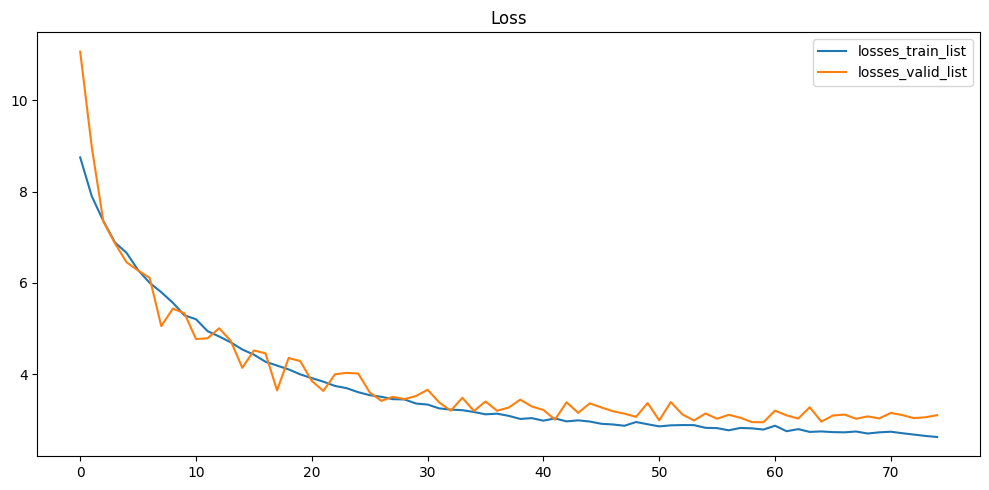

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
loss_pairs = [
    ('losses_train_list', 'losses_valid_list'), 
    ]
# Loop through each subplot

loss_pair = loss_pairs[0]
for loss in loss_pair:
    ax.plot(losses.__dict__[loss], label=loss)
    ax.set_title(loss) 

# Adjust layout for better spacing
plt.tight_layout()
plt.legend()
plt.title("Loss")
# Show the plots
plt.show()

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.04s/it]


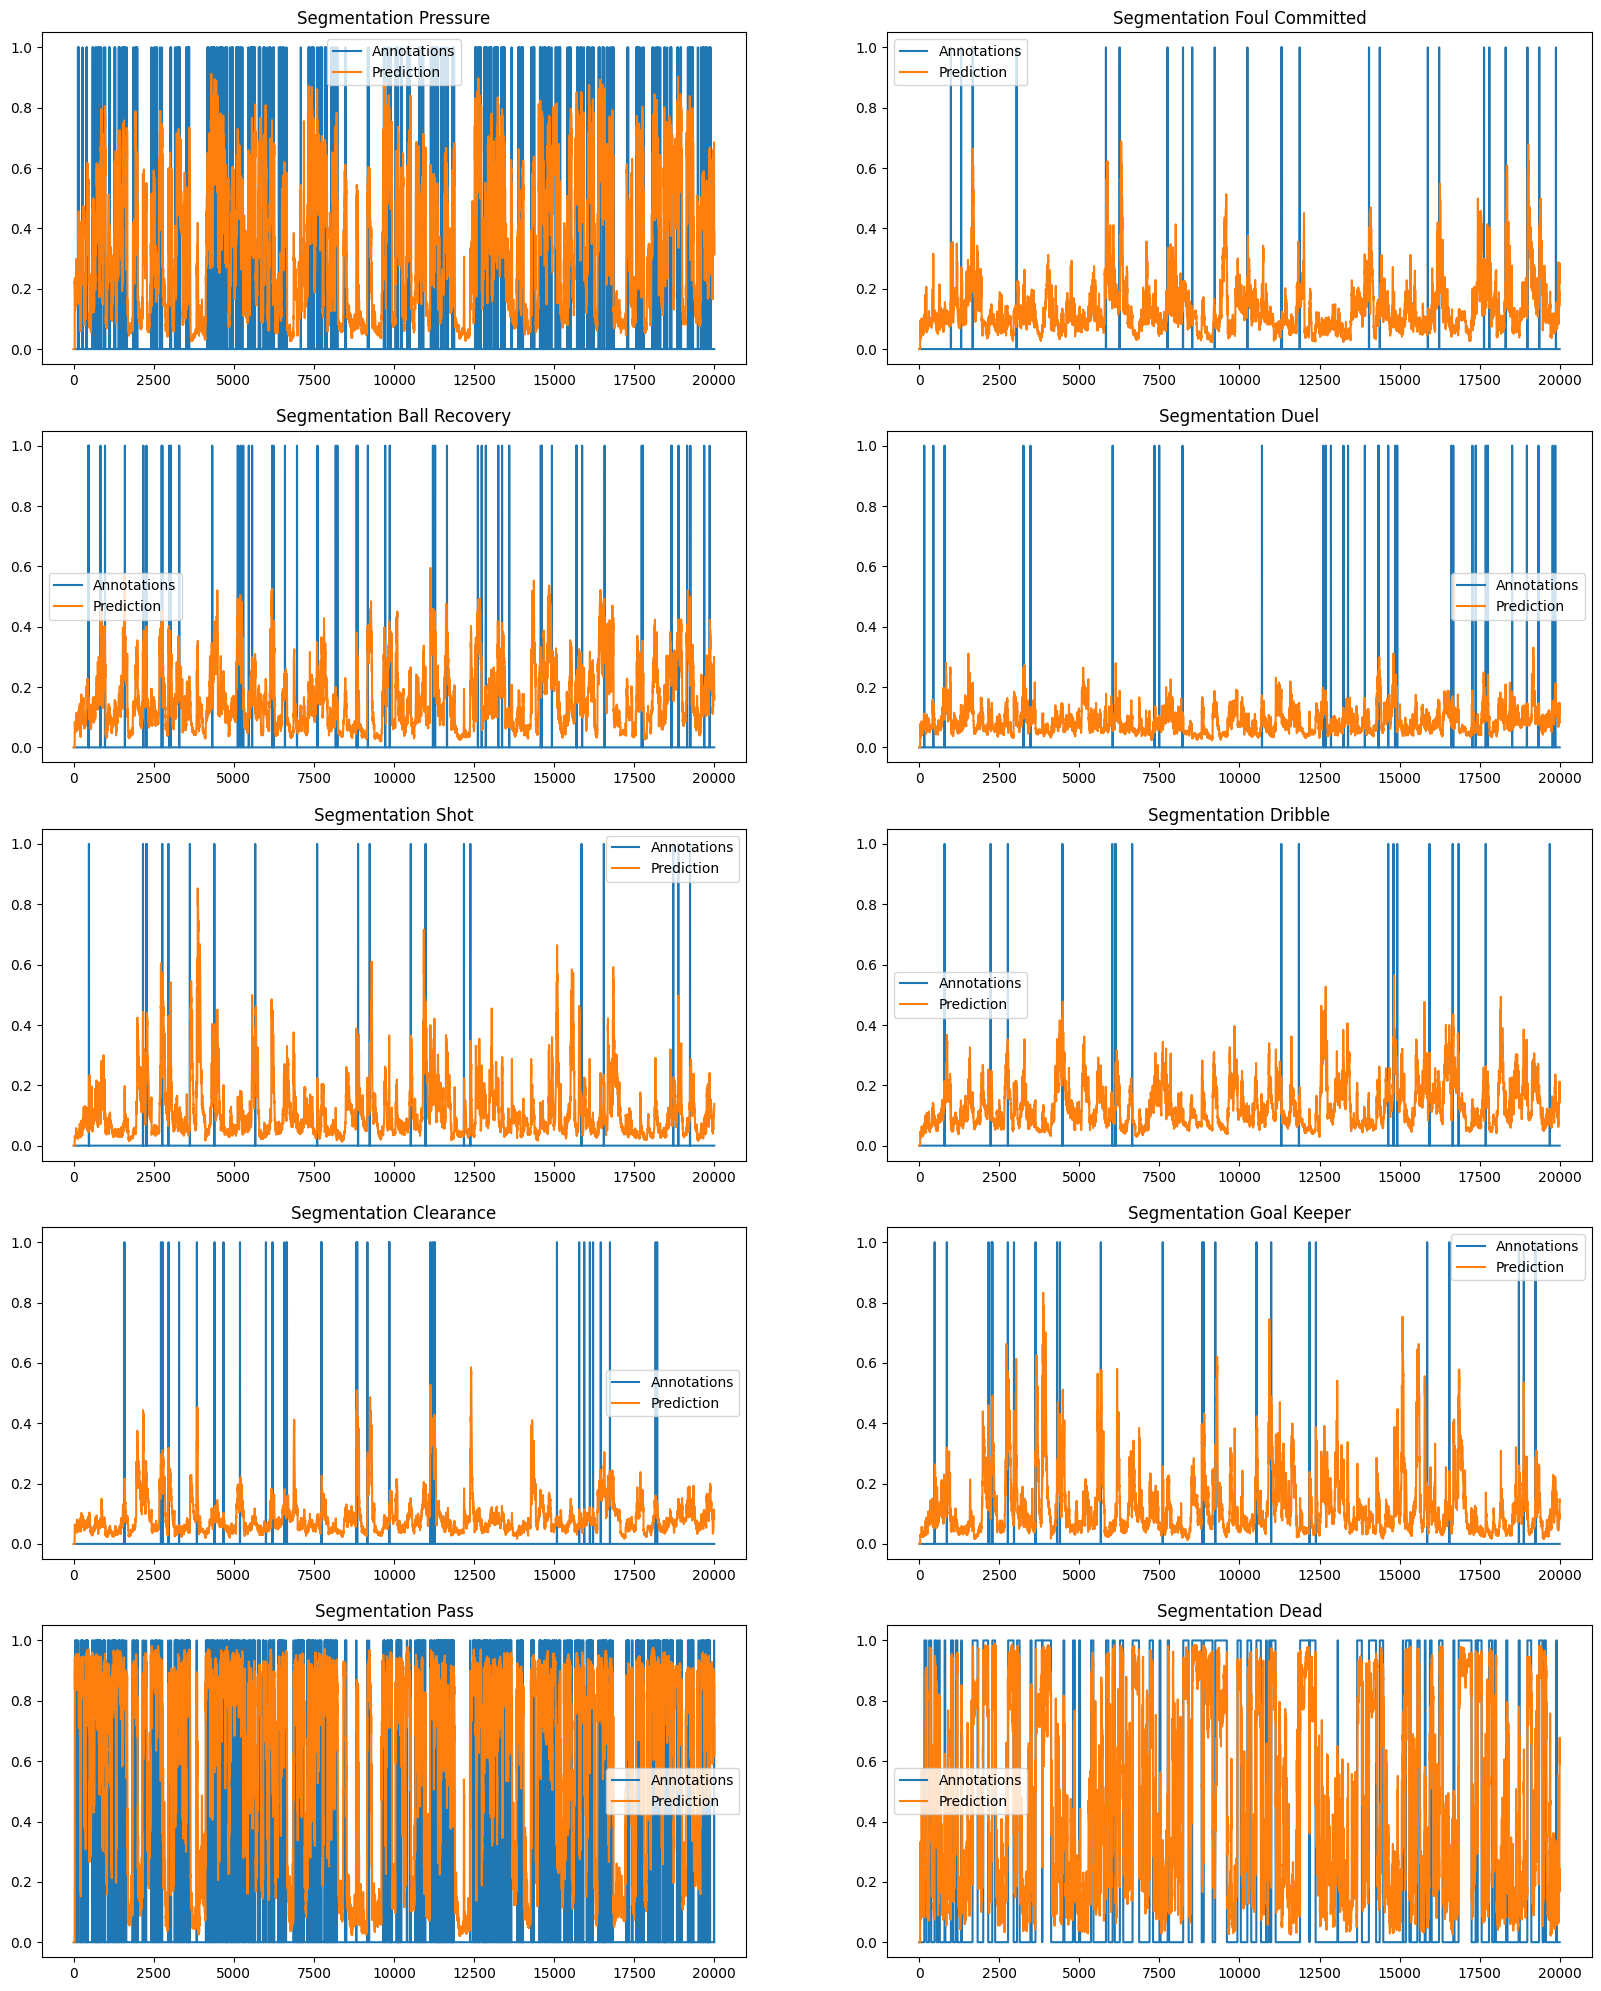

In [5]:
args = Args
collate_fn = collateVisGCN
model_path = f"models/CALF_NetVLAD_GCN.pth.tar"
model = torch.load(model_path)
model.eval()
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
fig, axes = visualiser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=None)

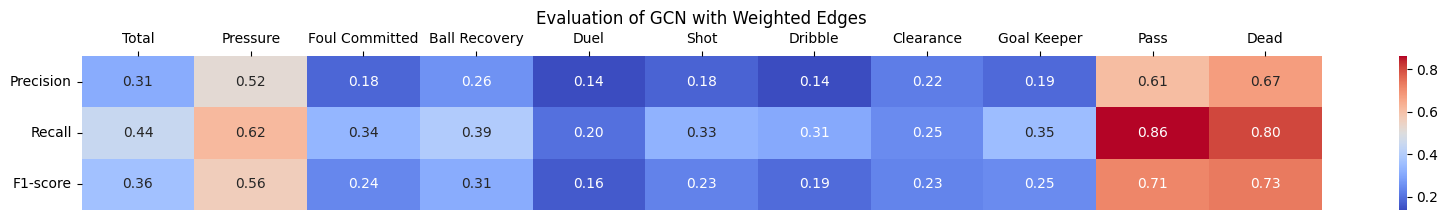

In [6]:
precision, recall, f1_score, _ = visualiser.norm_evaluation_segmentation()
precision = np.concatenate((np.array([np.mean(precision)]), precision))
recall = np.concatenate((np.array([np.mean(recall)]), recall))
f1_score = np.concatenate((np.array([np.mean(f1_score)]), f1_score))

cols = ["Total"] + list(event_enc.keys())
rows = ["Precision", "Recall", "F1-score"]

fig = plt.figure(figsize=(20, 2))

total_scores = np.concatenate((precision, recall, f1_score))
# ax1.set_title("Precision scores")
ax = sns.heatmap(total_scores.reshape(3,-1), annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()
ax.set_yticklabels(rows, rotation=0)

plt.title("Evaluation of GCN with Weighted Edges")
plt.show()

# TEST 2

In [3]:
@dataclass
class Args:
    # DATA
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 10
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GCN"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    vocab_size=64
    pooling="NetVLAD"

    # SPOTTING MODULE
    sgementation_path = None
    freeze_model = None

In [4]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = ContextAwareNetVladGlobal(args=args)
criterion = ContextAwareLoss(K=train_dataset.K_parameters)

optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    criterion,
                    model_name=args.model_name,
                    max_epochs=args.max_epochs, 
                    save_dir=f"models/CALF_NetVLAD_GCN2.pth.tar")

del train_dataset, validation_dataset, train_loader, validate_loader

with open(f'results/CALF_NetVLAD_GCN2.pkl', 'wb') as file:
    pickle.dump(losses, file)

Data preprocessing:   0%|          | 0/10 [00:00<?, ?it/s]

Get labels & features: 100%|██████████| 8/8 [01:11<00:00,  8.92s/it]
Train 1: Time 2.169s (it:2.238s) Data:0.893s (it:0.856s) Loss 8.8159e+00 : 100%|████████████████████████████████████████████████| 57/57 [02:03<00:00,  2.17s/it]
Evaluate 1: Time 1.486s (it:1.325s) Data:0.790s (it:0.659s) Loss 1.0261e+01 : 100%|█████████████████████████████████████████████| 57/57 [01:24<00:00,  1.49s/it]
Train 2: Time 2.074s (it:1.834s) Data:0.805s (it:0.698s) Loss 7.9408e+00 : 100%|████████████████████████████████████████████████| 57/57 [01:58<00:00,  2.07s/it]
Evaluate 2: Time 1.451s (it:1.363s) Data:0.771s (it:0.665s) Loss 8.5448e+00 : 100%|█████████████████████████████████████████████| 57/57 [01:22<00:00,  1.45s/it]
Train 3: Time 2.062s (it:2.293s) Data:0.836s (it:0.723s) Loss 7.4123e+00 : 100%|████████████████████████████████████████████████| 57/57 [01:57<00:00,  2.06s/it]
Evaluate 3: Time 1.589s (it:1.343s) Data:0.827s (it:0.639s) Loss 7.2951e+00 : 100%|███████████████████████████████████████████

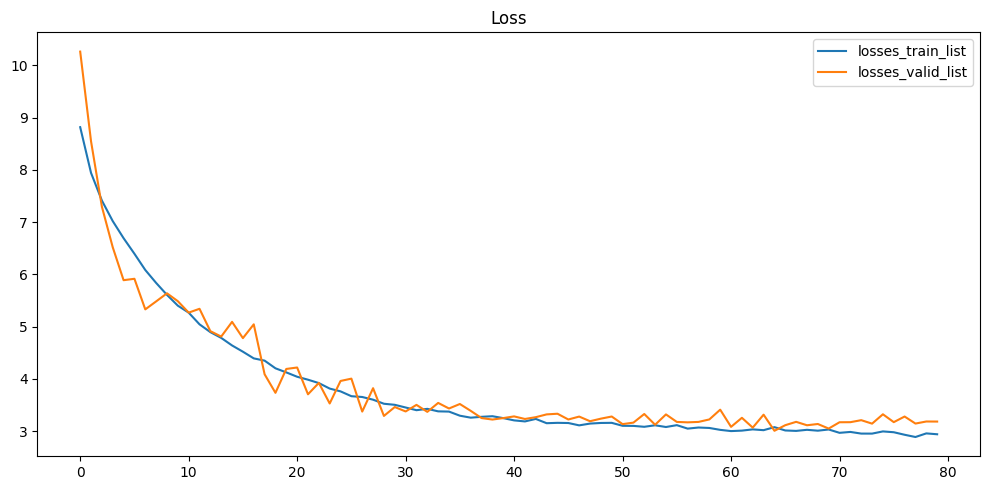

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
loss_pairs = [
    ('losses_train_list', 'losses_valid_list'), 
    ]
# Loop through each subplot

loss_pair = loss_pairs[0]
for loss in loss_pair:
    ax.plot(losses.__dict__[loss], label=loss)
    ax.set_title(loss) 

# Adjust layout for better spacing
plt.tight_layout()
plt.legend()
plt.title("Loss")
# Show the plots
plt.show()

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


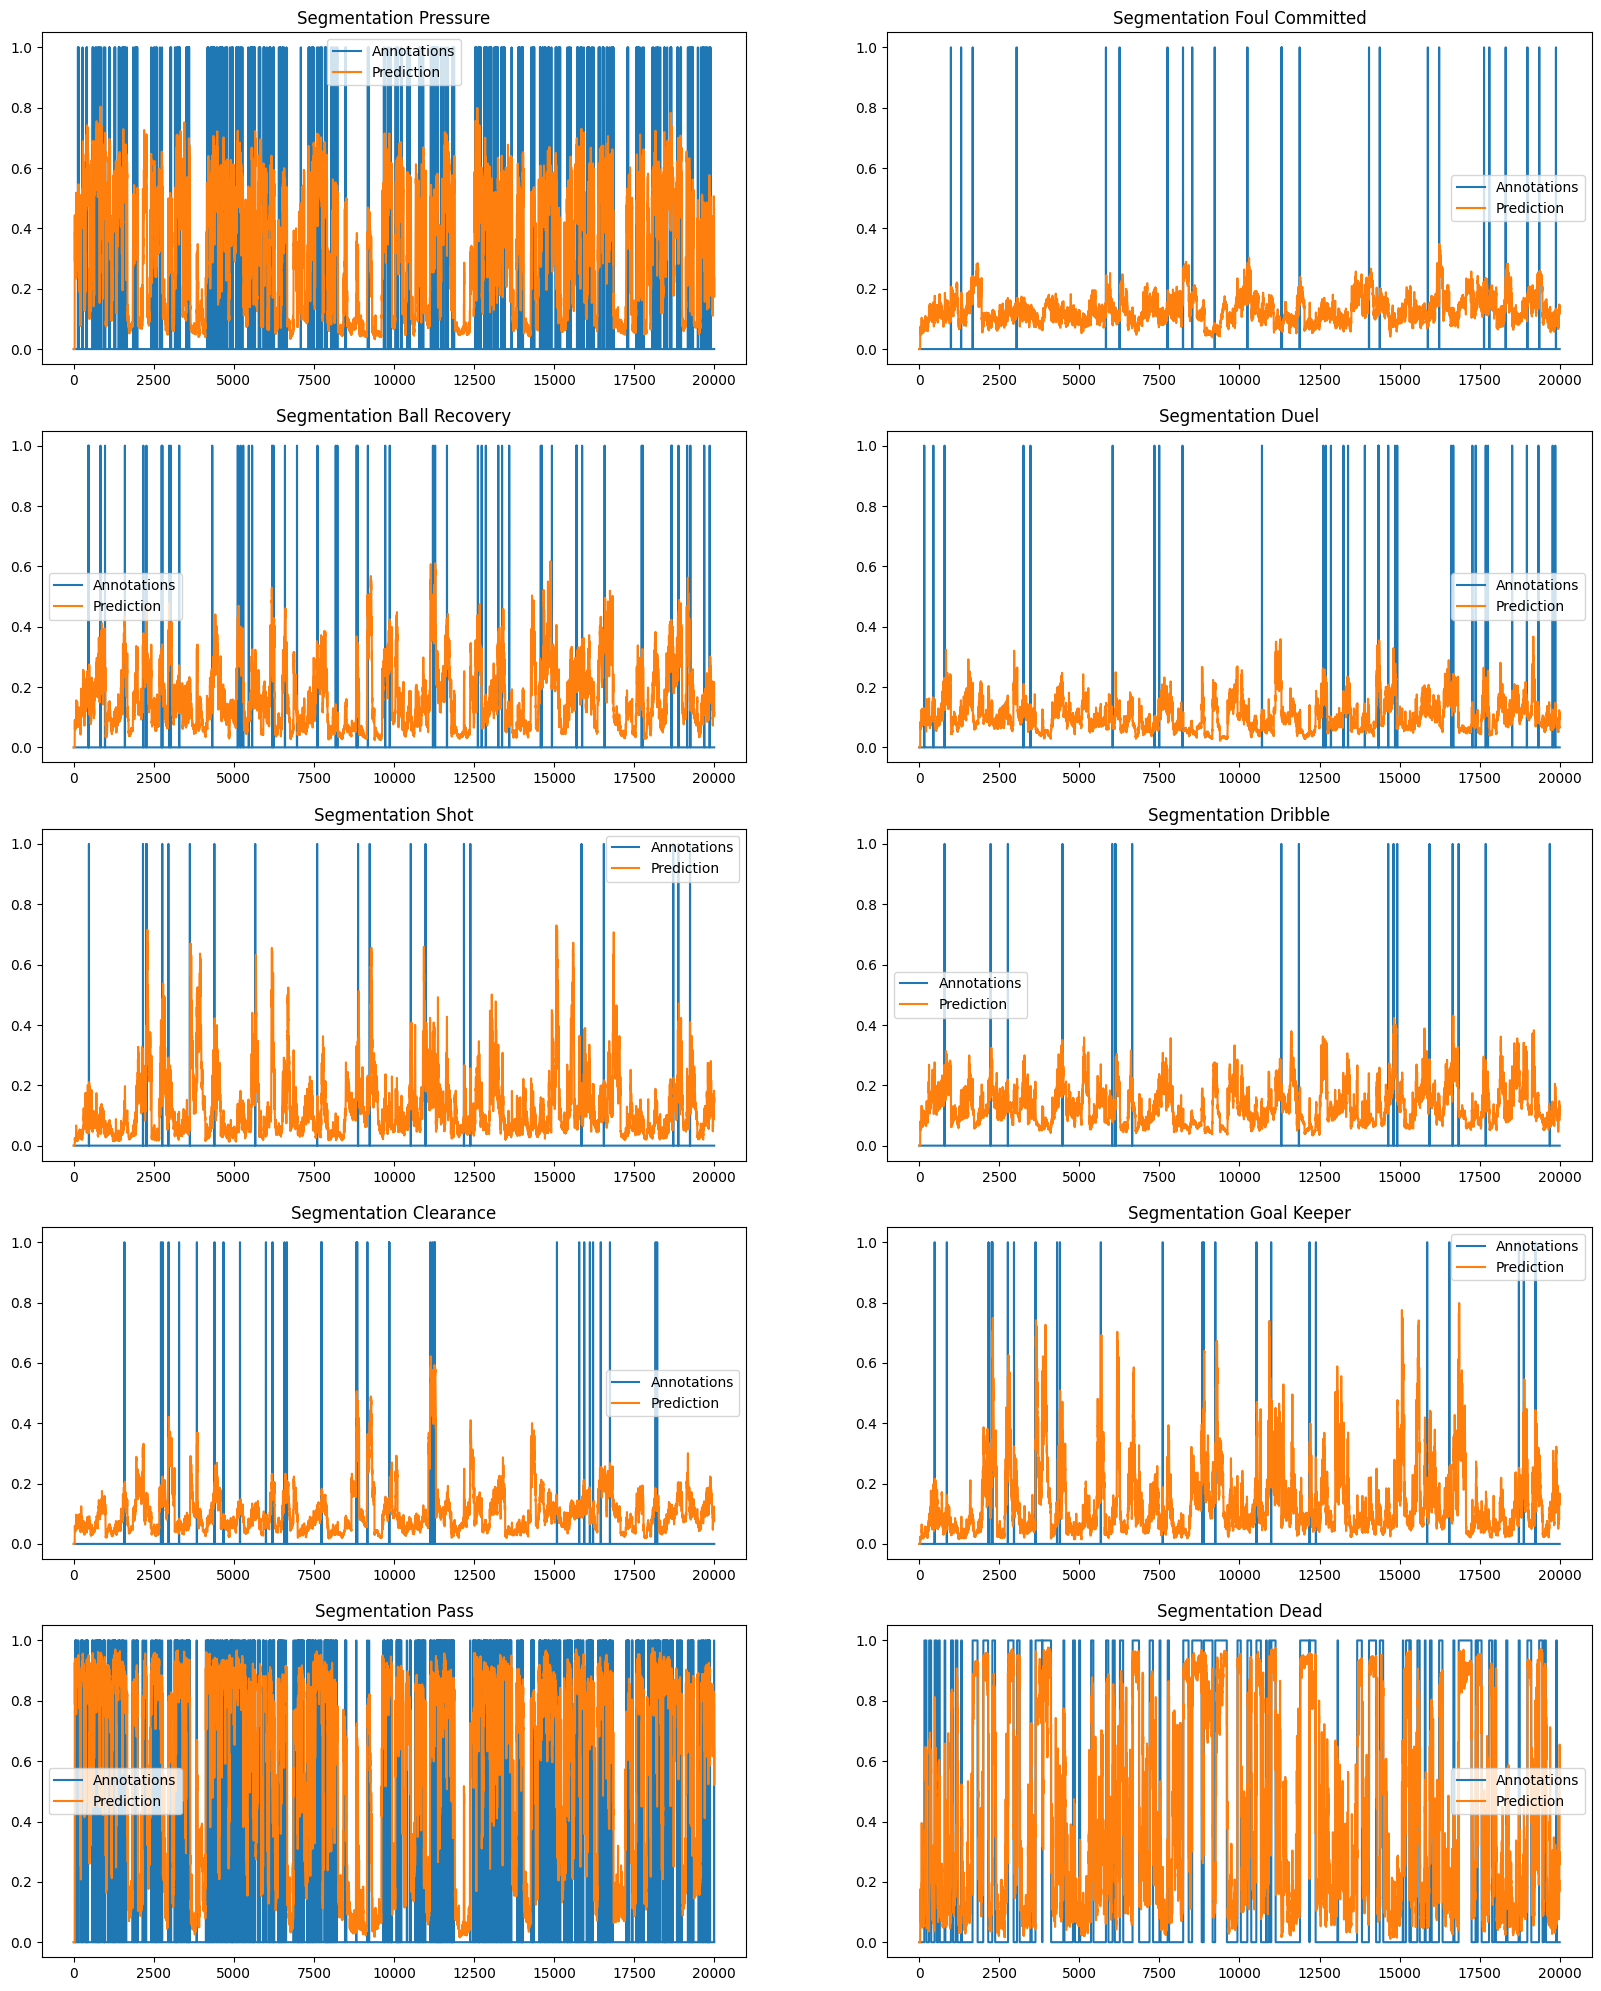

In [4]:
args = Args
collate_fn = collateVisGCN
model_path = f"models/CALF_NetVLAD_GCN2.pth.tar"
model = torch.load(model_path)
model.eval()
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
fig, axes = visualiser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=None)

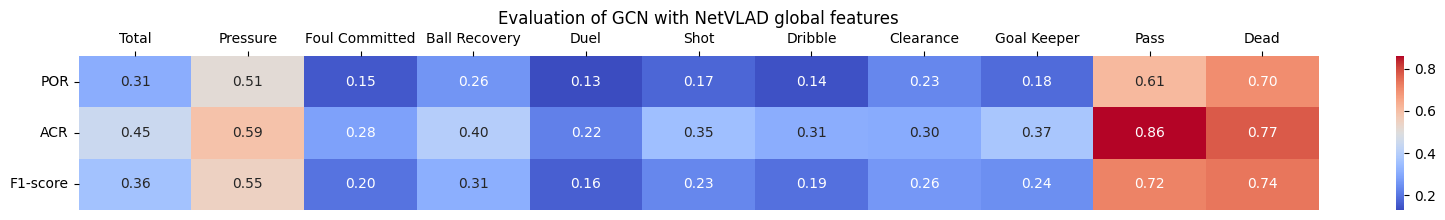

In [6]:
precision, recall, f1_score, _ = visualiser.norm_evaluation_segmentation()
precision = np.concatenate((np.array([np.mean(precision)]), precision))
recall = np.concatenate((np.array([np.mean(recall)]), recall))
f1_score = np.concatenate((np.array([np.mean(f1_score)]), f1_score))

cols = ["Total"] + list(event_enc.keys())
rows = ["POR", "ACR", "F1-score"]

fig = plt.figure(figsize=(20, 2))

total_scores = np.concatenate((precision, recall, f1_score))
# ax1.set_title("Precision scores")
ax = sns.heatmap(total_scores.reshape(3,-1), annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()
ax.set_yticklabels(rows, rotation=0)

plt.title("Evaluation of GCN with NetVLAD global features")
plt.show()

# NETVLAD AS A GLOBAL INFO

In [2]:
@dataclass
class Args:
    # DATA
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 10
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GCN"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    vocab_size=64
    pooling="NetVLAD"

    # SPOTTING MODULE
    sgementation_path = None
    freeze_model = None

In [3]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = ContextAwareNetVladGlobal(args=args)
criterion = ContextAwareLoss(K=train_dataset.K_parameters)

optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    criterion,
                    model_name=args.model_name,
                    max_epochs=args.max_epochs, 
                    save_dir=f"models/CALF_NetVLAD_GCN3.pth.tar")

del train_dataset, validation_dataset, train_loader, validate_loader

with open(f'results/CALF_NetVLAD_GCN3.pkl', 'wb') as file:
    pickle.dump(losses, file)

Get labels & features: 100%|██████████| 8/8 [01:08<00:00,  8.61s/it]
Train 1: Time 1.770s (it:1.685s) Data:0.786s (it:0.709s) Loss 8.9220e+00 : 100%|████████████████████████████████████████████████| 57/57 [01:40<00:00,  1.77s/it]
Evaluate 1: Time 1.179s (it:1.048s) Data:0.680s (it:0.610s) Loss 1.1782e+01 : 100%|█████████████████████████████████████████████| 57/57 [01:07<00:00,  1.18s/it]
Train 2: Time 1.747s (it:1.762s) Data:0.749s (it:0.678s) Loss 7.9187e+00 : 100%|████████████████████████████████████████████████| 57/57 [01:39<00:00,  1.75s/it]
Evaluate 2: Time 1.304s (it:1.108s) Data:0.752s (it:0.626s) Loss 8.9818e+00 : 100%|█████████████████████████████████████████████| 57/57 [01:14<00:00,  1.30s/it]
Train 3: Time 1.780s (it:1.676s) Data:0.760s (it:0.652s) Loss 7.4280e+00 : 100%|████████████████████████████████████████████████| 57/57 [01:41<00:00,  1.78s/it]
Evaluate 3: Time 1.234s (it:1.116s) Data:0.731s (it:0.623s) Loss 6.9710e+00 : 100%|███████████████████████████████████████████

# CONTEXTUALISED NETVLAD

In [2]:
@dataclass
class Args:
    # DATA
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 10
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GCN"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    vocab_size=16
    pooling="NetVLAD"

    # SPOTTING MODULE
    sgementation_path = None
    freeze_model = None

In [3]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = ContextAwareNetVladTemporal(args=args)
criterion = ContextAwareLoss(K=train_dataset.K_parameters)

optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    criterion,
                    model_name=args.model_name,
                    max_epochs=args.max_epochs, 
                    save_dir=f"models/CALF_NetVLAD_GCN_temporal.pth.tar")

del train_dataset, validation_dataset, train_loader, validate_loader

with open(f'results/CALF_NetVLAD_GCN3.pkl', 'wb') as file:
    pickle.dump(losses, file)

Get labels & features: 100%|██████████| 8/8 [01:08<00:00,  8.59s/it]
Train 1: Time 2.871s (it:2.765s) Data:0.782s (it:0.698s) Loss 8.8751e+00 : 100%|████████████████████████████████████████████████| 57/57 [02:43<00:00,  2.87s/it]
Evaluate 1: Time 2.007s (it:1.921s) Data:0.677s (it:0.611s) Loss 6.3010e+00 : 100%|█████████████████████████████████████████████| 57/57 [01:54<00:00,  2.01s/it]
Train 2: Time 2.933s (it:2.756s) Data:0.794s (it:0.676s) Loss 8.0834e+00 : 100%|████████████████████████████████████████████████| 57/57 [02:47<00:00,  2.93s/it]
Evaluate 2: Time 2.020s (it:1.980s) Data:0.706s (it:0.624s) Loss 6.9435e+00 : 100%|█████████████████████████████████████████████| 57/57 [01:55<00:00,  2.02s/it]
Train 3: Time 2.811s (it:2.784s) Data:0.745s (it:0.668s) Loss 7.4491e+00 : 100%|████████████████████████████████████████████████| 57/57 [02:40<00:00,  2.81s/it]
Evaluate 3: Time 2.017s (it:1.959s) Data:0.710s (it:0.626s) Loss 7.3460e+00 : 100%|███████████████████████████████████████████

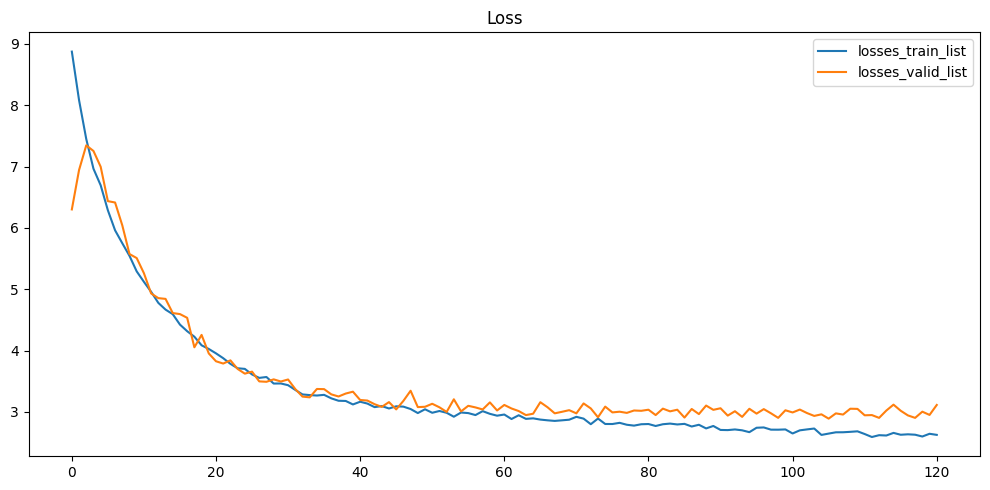

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
loss_pairs = [
    ('losses_train_list', 'losses_valid_list'), 
    ]
# Loop through each subplot

loss_pair = loss_pairs[0]
for loss in loss_pair:
    ax.plot(losses.__dict__[loss], label=loss)
    ax.set_title(loss) 

# Adjust layout for better spacing
plt.tight_layout()
plt.legend()
plt.title("Loss")
# Show the plots
plt.show()

Data preprocessing: 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]


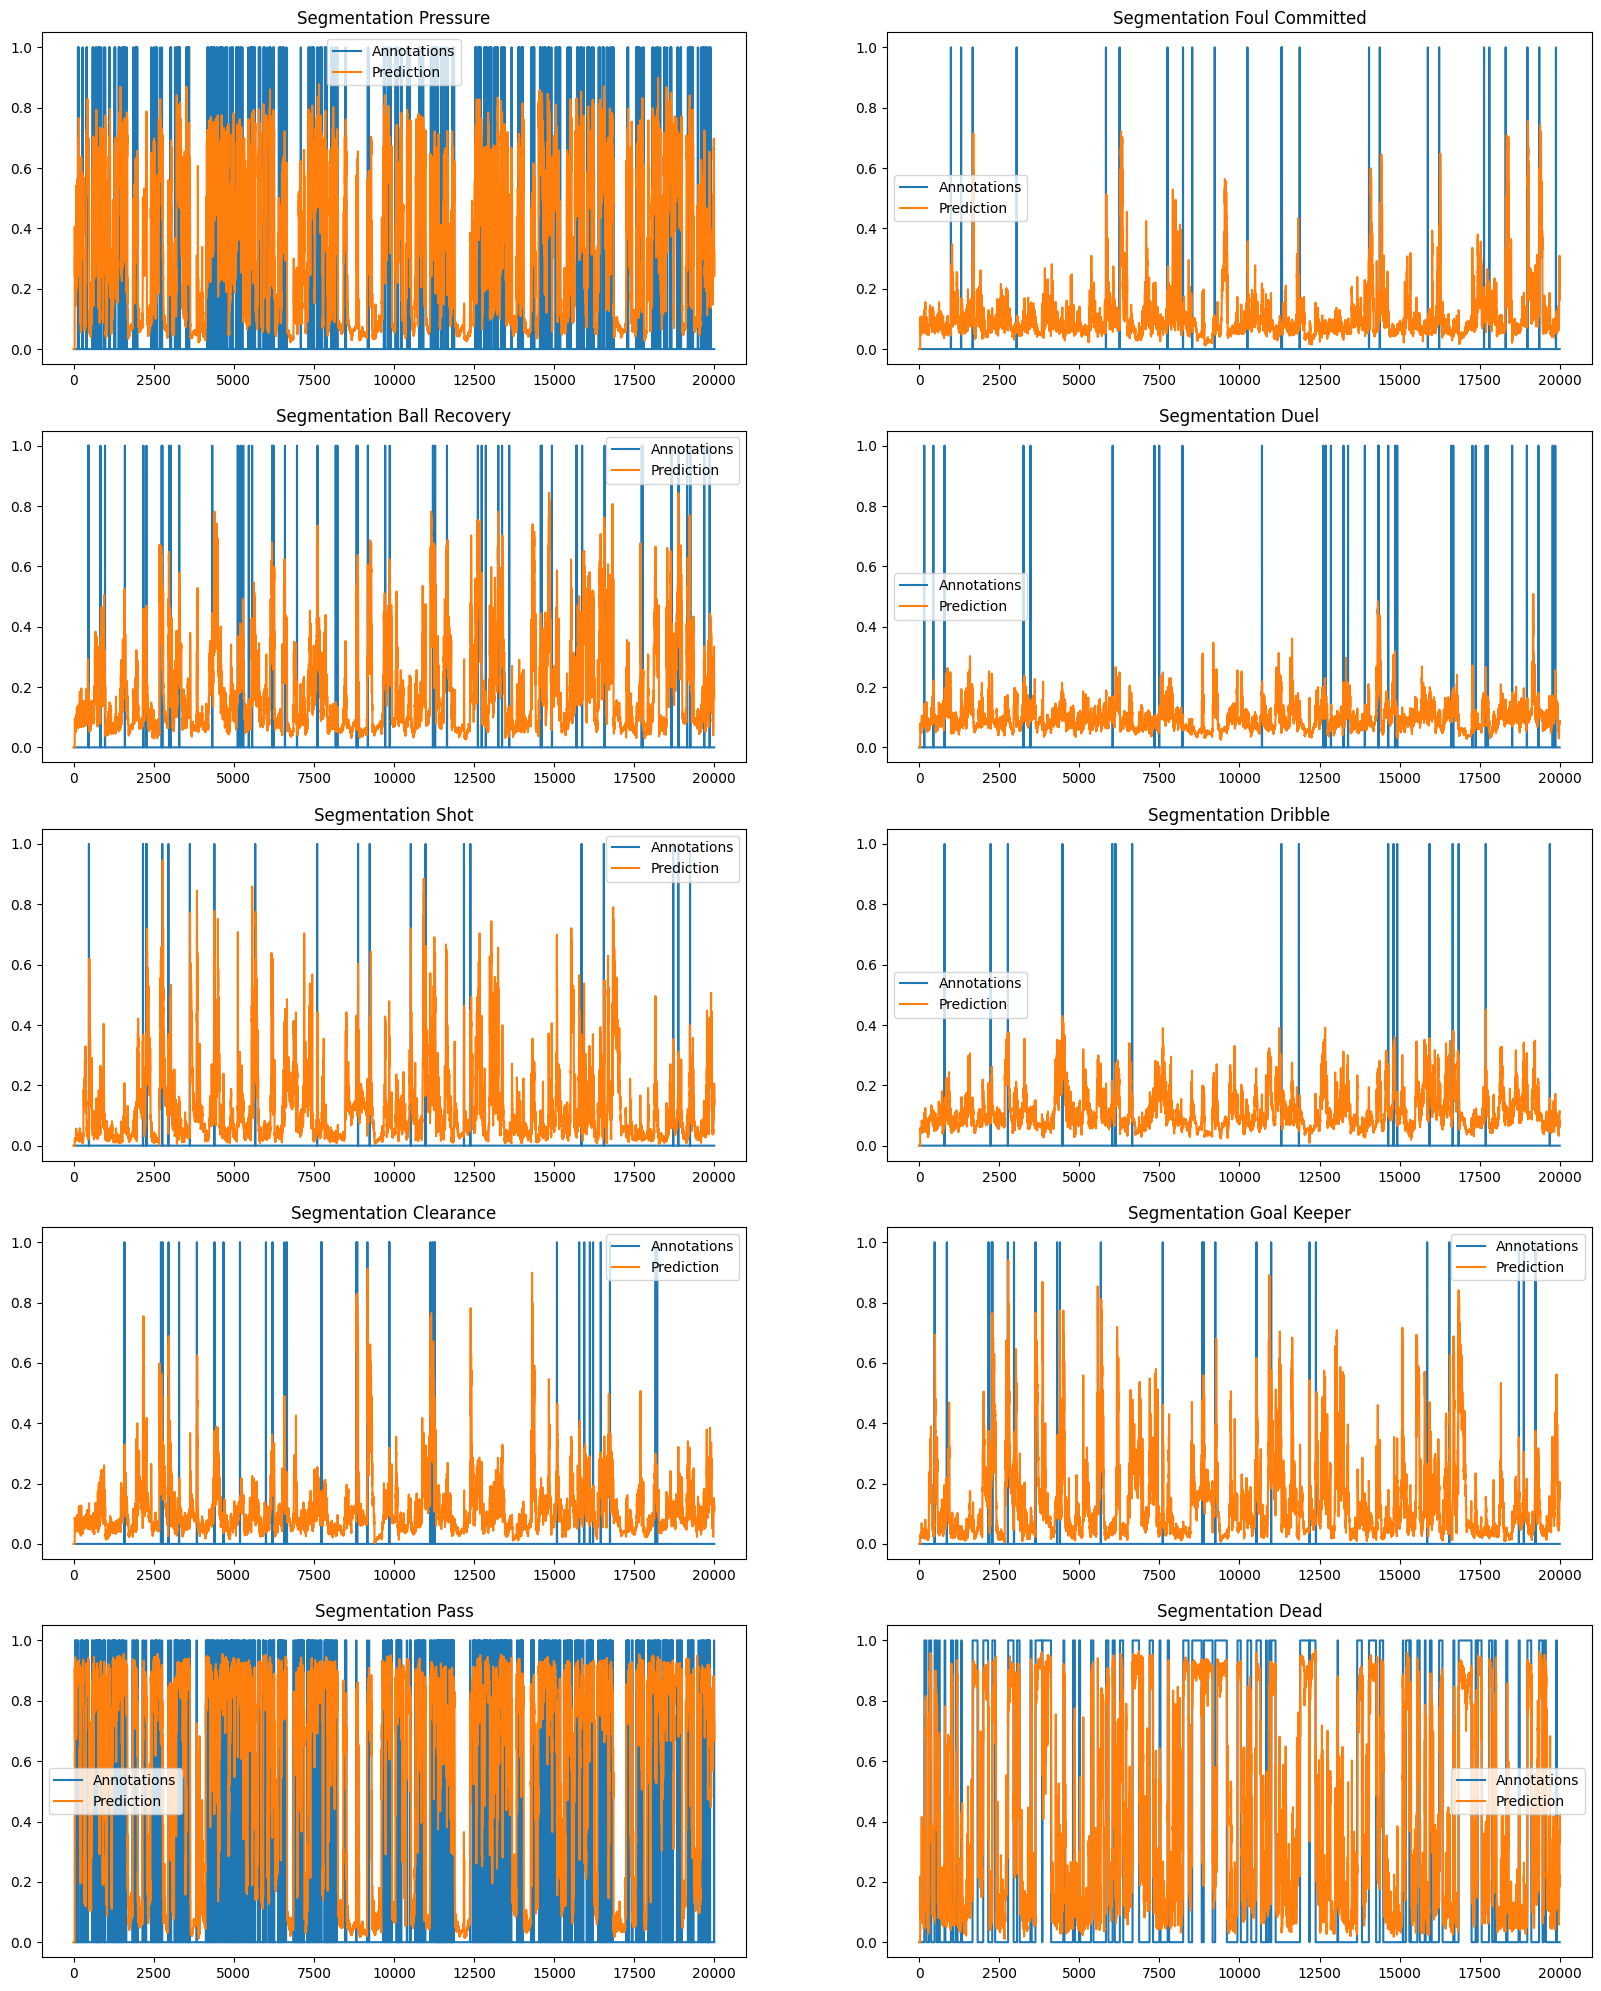

In [5]:
args = Args
collate_fn = collateVisGCN
model_path = f"models/CALF_NetVLAD_GCN_temporal.pth.tar"
model = torch.load(model_path)
model.eval()
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
fig, axes = visualiser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=None)

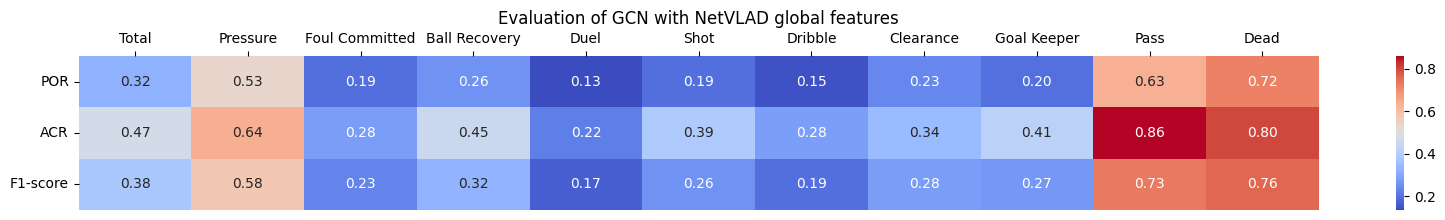

In [6]:
precision, recall, f1_score, _ = visualiser.norm_evaluation_segmentation()
precision = np.concatenate((np.array([np.mean(precision)]), precision))
recall = np.concatenate((np.array([np.mean(recall)]), recall))
f1_score = np.concatenate((np.array([np.mean(f1_score)]), f1_score))

cols = ["Total"] + list(event_enc.keys())
rows = ["POR", "ACR", "F1-score"]

fig = plt.figure(figsize=(20, 2))

total_scores = np.concatenate((precision, recall, f1_score))
# ax1.set_title("Precision scores")
ax = sns.heatmap(total_scores.reshape(3,-1), annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()
ax.set_yticklabels(rows, rotation=0)

plt.title("Evaluation of GCN with NetVLAD global features")
plt.show()